In [1]:
%matplotlib inline

# Yellowbrick Text Examples 

This notebook is a sample of the text visualizations that yellowbrick provides

In [2]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import yellowbrick as yb 
import matplotlib.pyplot as plt 

## Load Text Corpus for Example Code

Yellowbrick has provided a text corpus wrangled from the [Baleen RSS Corpus](http://baleen.districtdatalabs.com/) to present the following examples. If you haven't downloaded the data, you can do so by running:

```
$ python download.py
```

In the same directory as the text notebook. Note that this will create a directory called `data` that contains subdirectories with the provided datasets. 

In [3]:
from download import download_all 
from sklearn.datasets.base import Bunch

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "hobbies": os.path.join(FIXTURES, "hobbies")
}


def load_data(name, download=True):
    """
    Loads and wrangles the passed in text corpus by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
    
    # Read the directories in the directory as the categories. 
    categories = [
        cat for cat in os.listdir(path) 
        if os.path.isdir(os.path.join(path, cat))
    ]
    
    
    files  = [] # holds the file names relative to the root 
    data   = [] # holds the text read from the file 
    target = [] # holds the string of the category 
        
    # Load the data from the files in the corpus 
    for cat in categories:
        for name in os.listdir(os.path.join(path, cat)):
            files.append(os.path.join(path, cat, name))
            target.append(cat)
            
            with open(os.path.join(path, cat, name), 'r') as f:
                data.append(f.read())
        
    
    # Return the data bunch for use similar to the newsgroups example
    return Bunch(
        categories=categories,
        files=files,
        data=data,
        target=target,
    )

## t-SNE: Corpus Visualization 

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. Scikit-Learn implements this decomposition method as the `sklearn.manifold.TSNE` transformer. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot. 

Unfortunately, `TSNE` is very expensive, so typically a simpler decomposition method such as SVD or PCA is applied ahead of time. The `TSNEVisualizer` creates an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding. The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required. 

In [4]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Load the data and create document vectors 
corpus = load_data('hobbies')
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(corpus.data)
labels = corpus.target 

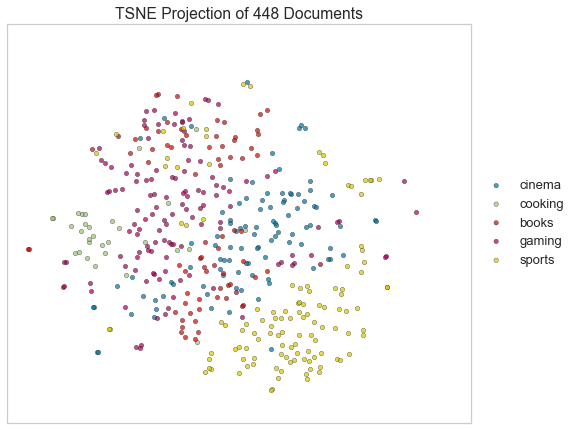

In [6]:
# Create the visualizer and draw the vectors 
tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

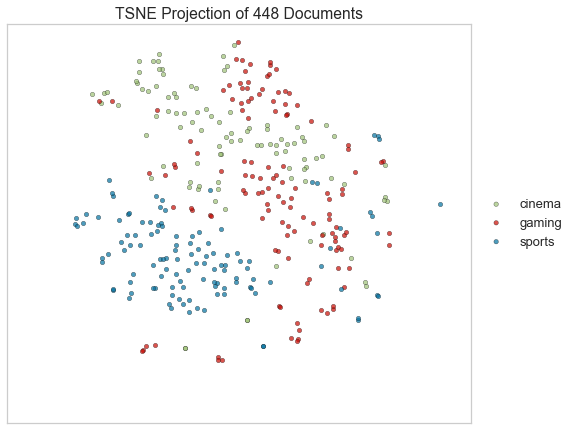

In [7]:
# Only visualize the sports, cinema, and gaming classes 
tsne = TSNEVisualizer(classes=['sports', 'cinema', 'gaming'])
tsne.fit(docs, labels)
tsne.poof()

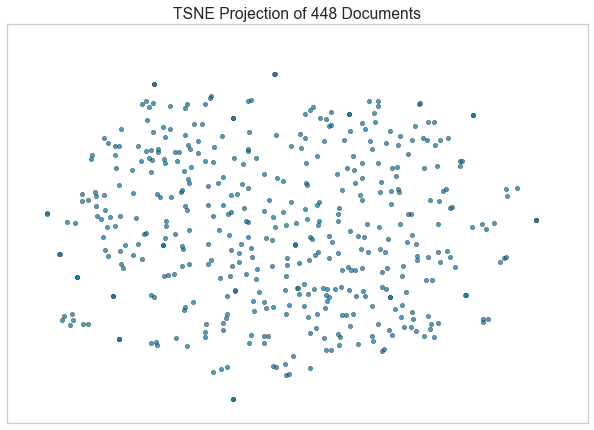

In [8]:
# Don't color points with their classes 
tsne = TSNEVisualizer()
tsne.fit(docs)
tsne.poof()

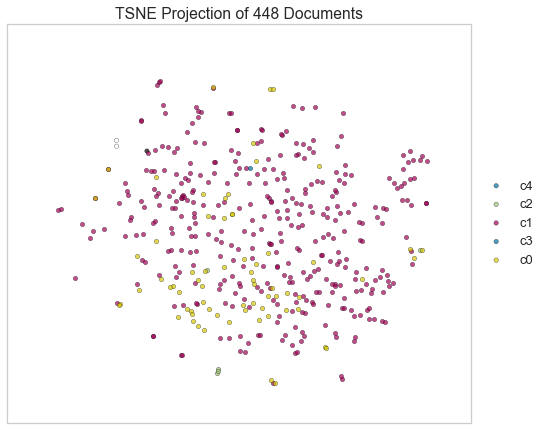

In [9]:
# Apply clustering instead of class names. 
from sklearn.cluster import MiniBatchKMeans 

clusters = MiniBatchKMeans(n_clusters=5)
clusters.fit(docs)

tsne = TSNEVisualizer() 
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

## Frequency Distribution Visualization 

A method for visualizing the frequency of tokens within and across corpora is frequency distribution. A frequency distribution tells us the frequency of each vocabulary item in the text. In general, it could count any kind of observable event. It is a distribution because it tells us how the total number of word tokens in the text are distributed across the vocabulary items.

In [10]:
from yellowbrick.text.freqdist import FreqDistVisualizer 
from sklearn.feature_extraction.text import CountVectorizer

Note that the `FreqDistVisualizer` does not perform any normalization or vectorization, and it expects text that has already be count vectorized.

We first instantiate a `FreqDistVisualizer` object, and then call `fit()` on that object with the count vectorized documents and the features (i.e. the words from the corpus), which computes the frequency distribution. The visualizer then plots a bar chart of the top 50 most frequent terms in the corpus, with the terms listed along the x-axis and frequency counts depicted at y-axis values. As with other Yellowbrick visualizers, when the user invokes `poof()`, the finalized visualization is shown.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


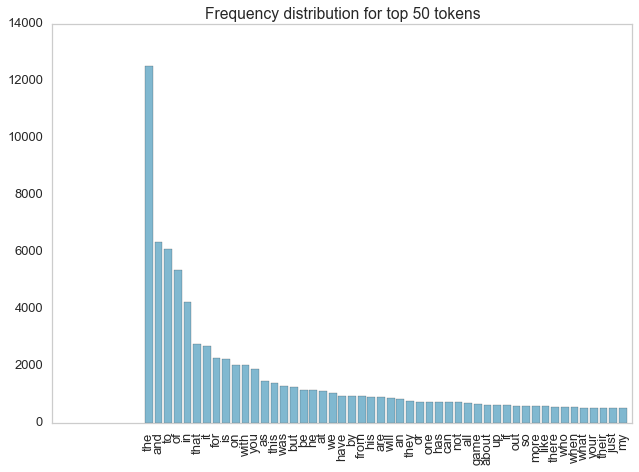

In [11]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(corpus.data)
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer()
visualizer.fit(docs, features)
visualizer.poof()

### Visualizing Stopwords Removal

For example, it is interesting to compare the results of the `FreqDistVisualizer` before and after stopwords have been removed from the corpus:

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


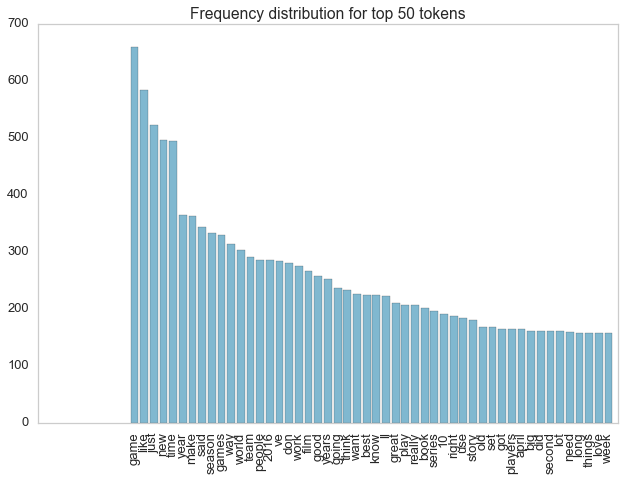

In [12]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(corpus.data)
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer()
visualizer.fit(docs, features)
visualizer.poof()

### Visualizing tokens across corpora

It is also interesting to explore the differences in tokens across a corpus. The hobbies corpus that comes with Yellowbrick has already been categorized (try `corpus['categories']`), so let's visually compare the differences in the frequency distributions for two of the categories: _"cooking"_ and _"gaming"_

In [13]:
hobby_types = {}

for category in corpus['categories']:
    texts = []
    for idx in range(len(corpus['data'])):
        if corpus['target'][idx] == category:
            texts.append(corpus['data'][idx])
    hobby_types[category] = texts

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


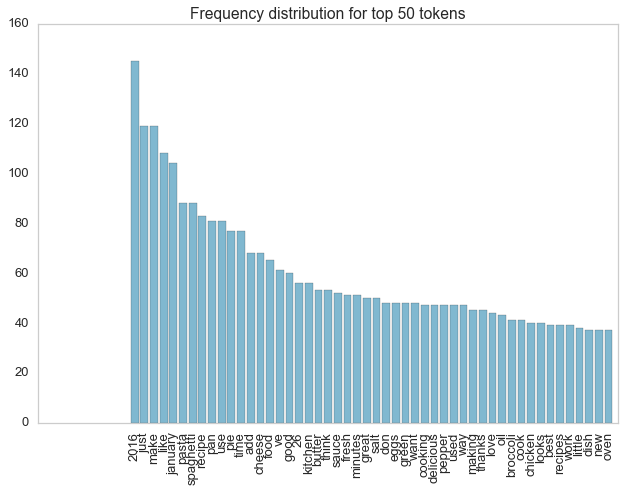

In [14]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(text for text in hobby_types['cooking'])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer()
visualizer.fit(docs, features)
visualizer.poof()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


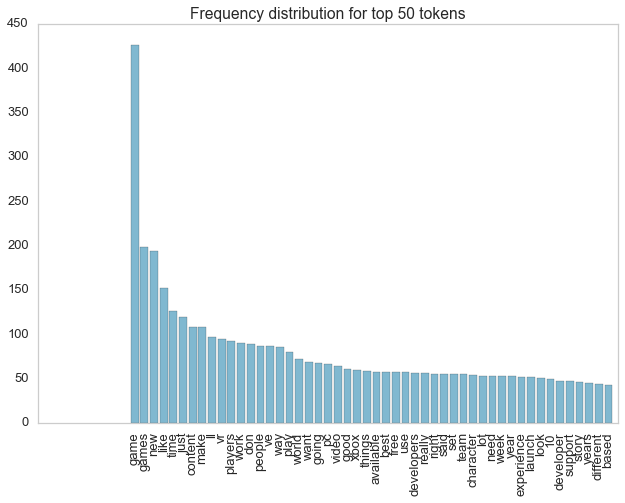

In [15]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(text for text in hobby_types['gaming'])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer()
visualizer.fit(docs, features)
visualizer.poof()